# 1. 변경된 prime time 코드 (기존 요일별 prime time에서 변경)
- 무형 데이터 분석한 결과 주말 18시와 19시 약 50%나 차지하고 있음
- sum으로 할 경우, 위의 시간대에 웨이트 값이 너무 낮게 도출됨. 
- 따라서 시간대별 매출액 sum을 하지 않고, 평균 매출액으로 prime time feature 사용.

# 2. 시간대별 상품군별 노출(분) 비율
- 특정 시간대에 특정 상품군이 어느 비중만큼 편성되어 있는지 나타내주는 feature
- 전처리에서 노출분 채워주는 부분을 생략해야 정확한 값이 나와서 그 부분 생략하고 진행했습니다!

# 3. 2번을 요일별로 나눠서 feature로 만들기


In [45]:
import pandas as pd
import numpy as np
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import platform


# if platform.system() == 'Windows':
# # 윈도우인 경우
#     font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
#     rc('font', family=font_name)
# else:    
# # Mac 인 경우
#     rc('font', family='AppleGothic')
    
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt 

import warnings

warnings.filterwarnings(action = 'ignore') 


try:
    if platform.system()=="Windows":
        font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/H2GTRM.ttf").get_name()
        rc("font",family=font_name)
    else:
        rc('font',family='AppleGothic')
except:
    pass

matplotlib.rcParams['axes.unicode_minus']=False

sales = pd.read_excel('sales.xlsx', header=1)
sales.head()

# 무형 지우기
sales.drop(sales[sales["상품군"]=="무형"].index, inplace=True)

# 판매단가 > 취급액 이면 취급액 = 0 

def custom(price, total):
    if price > total:
        return 0
    
    else:
        return total

sales["취급액"] = sales.apply(lambda x : custom(x["판매단가"], x["취급액"]), axis=1)

# 확인
print(sum((sales["판매단가"] > sales["취급액"]) & (sales['취급액'] != 0)))
sales

0


방송일시  노출(분)    마더코드    상품코드             상품명 상품군    판매단가  \
0     2019-01-01 06:00:00   20.0  100346  201072   테이트 남성 셀린니트3종  의류   39900   
1     2019-01-01 06:00:00    NaN  100346  201079   테이트 여성 셀린니트3종  의류   39900   
2     2019-01-01 06:20:00   20.0  100346  201072   테이트 남성 셀린니트3종  의류   39900   
3     2019-01-01 06:20:00    NaN  100346  201079   테이트 여성 셀린니트3종  의류   39900   
4     2019-01-01 06:40:00   20.0  100346  201072   테이트 남성 셀린니트3종  의류   39900   
...                   ...    ...     ...     ...             ...  ..     ...   
38299 2019-12-31 23:40:00    NaN  100448  201391   일시불쿠첸압력밥솥 6인용  주방  148000   
38300 2020-01-01 00:00:00   20.0  100448  201383  무이자쿠첸압력밥솥 10인용  주방  178000   
38301 2020-01-01 00:00:00    NaN  100448  201390  일시불쿠첸압력밥솥 10인용  주방  168000   
38302 2020-01-01 00:00:00    NaN  100448  201384   무이자쿠첸압력밥솥 6인용  주방  158000   
38303 2020-01-01 00:00:00    NaN  100448  201391   일시불쿠첸압력밥솥 6인용  주방  148000   

               취급액  
0        2099000.0  
1        4371000.0  
2        3262000.0  
3        6955000.0  
4        6672000.0  
...            ...  
38299   10157000.0  
38300   50929000.0  
38301  104392000.0  
38302   13765000.0  
38303   46608000.0  

[37372 rows x 8 columns]

In [46]:
# month, day, hour, minute, weekday 열 추가
sales['month'] = pd.DatetimeIndex(sales['방송일시']).month
sales['day'] = pd.DatetimeIndex(sales['방송일시']).day
sales['hour'] = pd.DatetimeIndex(sales['방송일시']).hour
sales['minute'] = pd.DatetimeIndex(sales['방송일시']).minute
sales['weekday'] = pd.DatetimeIndex(sales['방송일시']).weekday
sales['방송날짜'] = pd.DatetimeIndex(sales['방송일시']).date

sales.head()

방송일시  노출(분)    마더코드    상품코드            상품명 상품군   판매단가  \
0 2019-01-01 06:00:00   20.0  100346  201072  테이트 남성 셀린니트3종  의류  39900   
1 2019-01-01 06:00:00    NaN  100346  201079  테이트 여성 셀린니트3종  의류  39900   
2 2019-01-01 06:20:00   20.0  100346  201072  테이트 남성 셀린니트3종  의류  39900   
3 2019-01-01 06:20:00    NaN  100346  201079  테이트 여성 셀린니트3종  의류  39900   
4 2019-01-01 06:40:00   20.0  100346  201072  테이트 남성 셀린니트3종  의류  39900   

         취급액  month  day  hour  minute  weekday        방송날짜  
0  2099000.0      1    1     6       0        1  2019-01-01  
1  4371000.0      1    1     6       0        1  2019-01-01  
2  3262000.0      1    1     6      20        1  2019-01-01  
3  6955000.0      1    1     6      20        1  2019-01-01  
4  6672000.0      1    1     6      40        1  2019-01-01

In [47]:
# 무형이면서 주말 18,19시에 방송한 노출분을 확인해보자. 

# a = sales[sales["상품군"]=="무형"]
# b = a[a['weekday'].isin([5])]   
# c = b[b['hour'].isin([18,19])]
# c.sum()

# 1. 요일별 prime time 새로 만들기 

- 우선, 요일 나누지 말고 그래프를 그려보자.

In [48]:
sales.head()

방송일시  노출(분)    마더코드    상품코드            상품명 상품군   판매단가  \
0 2019-01-01 06:00:00   20.0  100346  201072  테이트 남성 셀린니트3종  의류  39900   
1 2019-01-01 06:00:00    NaN  100346  201079  테이트 여성 셀린니트3종  의류  39900   
2 2019-01-01 06:20:00   20.0  100346  201072  테이트 남성 셀린니트3종  의류  39900   
3 2019-01-01 06:20:00    NaN  100346  201079  테이트 여성 셀린니트3종  의류  39900   
4 2019-01-01 06:40:00   20.0  100346  201072  테이트 남성 셀린니트3종  의류  39900   

         취급액  month  day  hour  minute  weekday        방송날짜  
0  2099000.0      1    1     6       0        1  2019-01-01  
1  4371000.0      1    1     6       0        1  2019-01-01  
2  3262000.0      1    1     6      20        1  2019-01-01  
3  6955000.0      1    1     6      20        1  2019-01-01  
4  6672000.0      1    1     6      40        1  2019-01-01

In [49]:
# 일단, day 마다 hour를 기준으로 매출액이 sum 될 수 있도록 groupby 해줌.

processed = pd.DataFrame(sales.groupby(['month', 'day','hour'])['취급액'].sum()).reset_index()

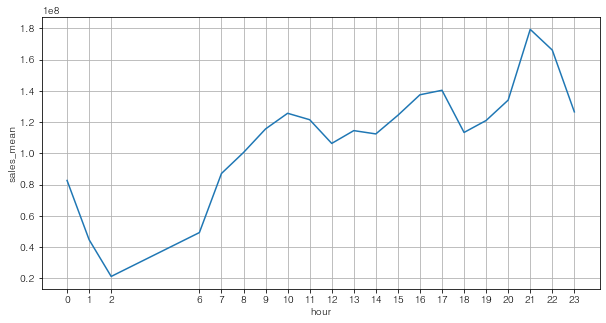

In [50]:
# hour 기준으로 모든 일의 취급액을 mean 해주기. -> 시간대별 평균 매출액 

hour_df = pd.DataFrame(processed.groupby(['hour'])['취급액'].mean())

# 그래프로 그려보기 

plt.figure(figsize = (10,5))
plt.plot(hour_df.index, hour_df['취급액'])
plt.xlabel("hour")
plt.ylabel("sales_mean")
plt.xticks(hour_df.index)
plt.grid()
plt.show()

# 요일별로 나눠서 시간대별 매출액(sum) 구하기-> feature로 활용하기

In [51]:
# day 마다 hour를 기준으로 매출액이 sum 될 수 있도록 groupby 해줌. weekday도 필요하니까 같이 

process_1 = sales.groupby(["month","day","hour","weekday"])[["취급액"]].sum().reset_index()
process_1.head()

month  day  hour  weekday          취급액
0      1    1     0        2  215694000.0
1      1    1     6        1   32696000.0
2      1    1     7        1   47878000.0
3      1    1     8        1   99736000.0
4      1    1     9        1   90973000.0

In [8]:
# hour, weekday 기준으로 모든 일의 취급액을 mean 해주기. -> 요일별 시간대별 평균 매출액 

# hour_df1 = pd.DataFrame(processed1.groupby(['hour', 'weekday'])['취급액'].mean()).reset_index()
# hour_df1.head()

# feature로 만들기 - sales에 merge

In [9]:
# column 이름 바꾸기
# hour_df1.rename(columns = {'취급액':'w_prime'}, inplace=True)

# sales = pd.merge(sales, hour_df1, on=['hour', 'weekday'])

# sales.head()

In [52]:
process_1 = sales.groupby(["month","day","hour","weekday"])[["취급액"]].sum().reset_index()
hour_df = process_1.groupby(["hour","weekday"]).mean()[["취급액"]].reset_index().rename(columns= {"취급액":"w_prime"})

sales = pd.merge(sales,hour_df, on =["hour","weekday"])
sales.head()

방송일시  노출(분)    마더코드    상품코드            상품명 상품군   판매단가  \
0 2019-01-01 06:00:00   20.0  100346  201072  테이트 남성 셀린니트3종  의류  39900   
1 2019-01-01 06:00:00    NaN  100346  201079  테이트 여성 셀린니트3종  의류  39900   
2 2019-01-01 06:20:00   20.0  100346  201072  테이트 남성 셀린니트3종  의류  39900   
3 2019-01-01 06:20:00    NaN  100346  201079  테이트 여성 셀린니트3종  의류  39900   
4 2019-01-01 06:40:00   20.0  100346  201072  테이트 남성 셀린니트3종  의류  39900   

         취급액  month  day  hour  minute  weekday        방송날짜       w_prime  
0  2099000.0      1    1     6       0        1  2019-01-01  4.771683e+07  
1  4371000.0      1    1     6       0        1  2019-01-01  4.771683e+07  
2  3262000.0      1    1     6      20        1  2019-01-01  4.771683e+07  
3  6955000.0      1    1     6      20        1  2019-01-01  4.771683e+07  
4  6672000.0      1    1     6      40        1  2019-01-01  4.771683e+07

# 요일별 df 및 그래프로 확인하기


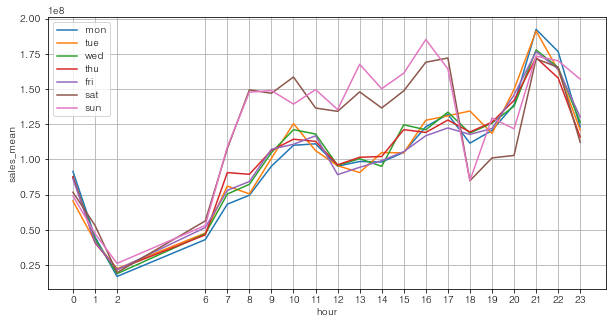

In [53]:
# 요일별로 필터 적용한 dataframe 만들기 

mon_df = hour_df[hour_df['weekday']==0]
tue_df = hour_df[hour_df['weekday']==1]
wed_df = hour_df[hour_df['weekday']==2]
thu_df = hour_df[hour_df['weekday']==3]
fri_df = hour_df[hour_df['weekday']==4]
sat_df = hour_df[hour_df['weekday']==5]
sun_df = hour_df[hour_df['weekday']==6]

# 그래프 그리기 

fig, ax = plt.subplots(figsize=(10,5)) 

# 평일 추이 그려보기. 
ax.plot(mon_df['hour'],mon_df['w_prime'], label='mon')
ax.plot(tue_df['hour'],tue_df['w_prime'], label='tue')
ax.plot(wed_df['hour'], wed_df['w_prime'], label='wed')
ax.plot(thu_df['hour'],thu_df['w_prime'], label='thu')
ax.plot(fri_df ['hour'],fri_df['w_prime'], label='fri')

# # 주말 추이도 그려보자. (갈색 - 토요일 / 핑크 - 일요일)
ax.plot(sat_df['hour'],sat_df['w_prime'], label='sat')
ax.plot(sun_df['hour'],sun_df['w_prime'], label='sun')

plt.xticks(mon_df['hour'])

plt.xlabel('hour')
plt.ylabel('sales_mean')
plt.grid()

plt.legend(loc='upper left')

# 2. 시간대별 상품군별 방송 노출 비율 feature로 넣기 
- 노출분이 매출액과 상관관계를 어느정도 보이고 있기 때문에 활용해보고자 한다. 

In [54]:
# 시간대별 방송 편성 노출분 feature 만들기 

broad_time = sales.groupby(['hour','상품군']).sum()['노출(분)']
bt_df= pd.DataFrame(broad_time)

bt_df = bt_df.rename(columns={'노출(분)' : 'prime_categ'}).reset_index()


# 시간대별 노출분 sum 구하기 
hour_sum = pd.DataFrame(bt_df.groupby('hour')['prime_categ'].sum()).reset_index()


# 시간대별 상품군별 노출분 column 합치기
btdf = pd.merge(bt_df,hour_sum, on="hour")

# 각각 상품군별 노출분을 시간대별 전체 노출분으로나눠주기. 즉 시간대별로 각 상품군이 몇퍼센트의 비율로 노출되었는지 보여줌. 
# prime_categ_x : 상품군별 노출분 칼럼
# prime_categ_y : 시간대별로 노출분 sum한것 

btdf['broad_rate'] = btdf['prime_categ_x'] / btdf['prime_categ_y']

# 잘 들어갔는지 확인 
# rate 다 더하면 1 
btdf[btdf['hour']==0].sum()

btdf

hour   상품군  prime_categ_x  prime_categ_y  broad_rate
0       0    가구     540.000000   16546.266667    0.032636
1       0    가전     520.000000   16546.266667    0.031427
2       0  건강기능     380.000000   16546.266667    0.022966
3       0   농수축     105.466667   16546.266667    0.006374
4       0  생활용품    2100.000000   16546.266667    0.126917
..    ...   ...            ...            ...         ...
209    23    의류    2920.000000   18397.466667    0.158718
210    23   이미용    1047.266667   18397.466667    0.056925
211    23    잡화     980.200000   18397.466667    0.053279
212    23    주방     700.000000   18397.466667    0.038049
213    23    침구     180.000000   18397.466667    0.009784

[214 rows x 5 columns]

In [55]:
# 필요 없는 column drop 

try :
    btdf.drop(['prime_categ_x', 'prime_categ_y'], inplace=True, axis=1)
    
except :
     print('change already done.')
        
btdf.head()

hour   상품군  broad_rate
0     0    가구    0.032636
1     0    가전    0.031427
2     0  건강기능    0.022966
3     0   농수축    0.006374
4     0  생활용품    0.126917

In [56]:
# sales에 merge하기 

sales = pd.merge(sales, btdf)

# 잘 들어갔는지 확인 
# sales[sales['hour']==10]

sales.head()

방송일시  노출(분)    마더코드    상품코드            상품명 상품군   판매단가  \
0 2019-01-01 06:00:00   20.0  100346  201072  테이트 남성 셀린니트3종  의류  39900   
1 2019-01-01 06:00:00    NaN  100346  201079  테이트 여성 셀린니트3종  의류  39900   
2 2019-01-01 06:20:00   20.0  100346  201072  테이트 남성 셀린니트3종  의류  39900   
3 2019-01-01 06:20:00    NaN  100346  201079  테이트 여성 셀린니트3종  의류  39900   
4 2019-01-01 06:40:00   20.0  100346  201072  테이트 남성 셀린니트3종  의류  39900   

         취급액  month  day  hour  minute  weekday        방송날짜       w_prime  \
0  2099000.0      1    1     6       0        1  2019-01-01  4.771683e+07   
1  4371000.0      1    1     6       0        1  2019-01-01  4.771683e+07   
2  3262000.0      1    1     6      20        1  2019-01-01  4.771683e+07   
3  6955000.0      1    1     6      20        1  2019-01-01  4.771683e+07   
4  6672000.0      1    1     6      40        1  2019-01-01  4.771683e+07   

   broad_rate  
0    0.283897  
1    0.283897  
2    0.283897  
3    0.283897  
4    0.283897

# 3. 2번을 더 세분화된 feature로 만들기 : 요일별로 만들기 

- 월-목 / 금 / 토 / 일 -> 이렇게 크게 4가지로 묶어서 feature 만들어보고 싶은데 코딩 방법을 모름.. 

- 상품군별 비중 그래프를 요일별로 봤을때 추이가 비슷한것 끼리 묶었음
- 요일별 그래프는 PPT 참고해주세요 

In [57]:
# 요일별 시간대별 상품군의 노출분 df 만들기 

week_df = pd.DataFrame(sales.groupby(['weekday','hour','상품군'])['노출(분)'].sum()).reset_index()
week_df

# 요일별 시간대별 전체 노출분 df 만들기 
broad_sum = pd.DataFrame(week_df.groupby(['weekday','hour'])['노출(분)'].sum()).reset_index()


# # 나눠주기 위해 하나의 df로 합쳐주기 
week = pd.merge(week_df, broad_sum, on=['weekday','hour'])

# # 나눠주기 -> 비율 알아내기 위함 
# # btdf['노출(분)_x'] : 시간대별 상품군별 노출분 
# # btdf['노출(분)_y'] : 시간대별 전체 상품군의 노출분 합 

week['w_broad'] = week['노출(분)_x'] / week['노출(분)_y'] 

week

weekday  hour   상품군  노출(분)_x  노출(분)_y   w_broad
0           0     0    가구    200.0   2960.2  0.067563
1           0     0    가전     40.0   2960.2  0.013513
2           0     0  건강기능     40.0   2960.2  0.013513
3           0     0   농수축     40.0   2960.2  0.013513
4           0     0  생활용품    560.0   2960.2  0.189176
...       ...   ...   ...      ...      ...       ...
1190        6    23    속옷    740.0   3140.2  0.235654
1191        6    23    의류    640.0   3140.2  0.203809
1192        6    23   이미용    120.0   3140.2  0.038214
1193        6    23    잡화    180.2   3140.2  0.057385
1194        6    23    주방    200.0   3140.2  0.063690

[1195 rows x 6 columns]

In [58]:
# 필요 없는 column drop 

try :
    week.drop(['노출(분)_x', '노출(분)_y'], inplace=True, axis=1)
    
except :
     print('change already done.')


# 값 잘 들어갔는지 확인 절차 
# 하나의 요일에 시간대별로 1씩 들어가니까, 21
week[week['weekday']==1]['w_broad'].sum()

21.0

In [59]:
week.head()

weekday  hour   상품군   w_broad
0        0     0    가구  0.067563
1        0     0    가전  0.013513
2        0     0  건강기능  0.013513
3        0     0   농수축  0.013513
4        0     0  생활용품  0.189176

In [60]:
#sales에 merge하기 

sales = pd.merge(sales ,week)
sales.head()

방송일시  노출(분)    마더코드    상품코드            상품명 상품군   판매단가  \
0 2019-01-01 06:00:00   20.0  100346  201072  테이트 남성 셀린니트3종  의류  39900   
1 2019-01-01 06:00:00    NaN  100346  201079  테이트 여성 셀린니트3종  의류  39900   
2 2019-01-01 06:20:00   20.0  100346  201072  테이트 남성 셀린니트3종  의류  39900   
3 2019-01-01 06:20:00    NaN  100346  201079  테이트 여성 셀린니트3종  의류  39900   
4 2019-01-01 06:40:00   20.0  100346  201072  테이트 남성 셀린니트3종  의류  39900   

         취급액  month  day  hour  minute  weekday        방송날짜       w_prime  \
0  2099000.0      1    1     6       0        1  2019-01-01  4.771683e+07   
1  4371000.0      1    1     6       0        1  2019-01-01  4.771683e+07   
2  3262000.0      1    1     6      20        1  2019-01-01  4.771683e+07   
3  6955000.0      1    1     6      20        1  2019-01-01  4.771683e+07   
4  6672000.0      1    1     6      40        1  2019-01-01  4.771683e+07   

   broad_rate   w_broad  
0    0.283897  0.297297  
1    0.283897  0.297297  
2    0.283897  0.297297  
3    0.283897  0.297297  
4    0.283897  0.297297